The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0


# Softmax Regression Implementation from Scratch
:label:`sec_softmax_scratch`

Because softmax regression is so fundamental,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [1]:
from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l

npx.set_np()

## The Softmax

Let's begin with the most important part:
the mapping from scalars to probabilities.
For a refresher, recall the operation of the sum operator
along specific dimensions in a tensor,
as discussed in :numref:`subsec_lin-alg-reduction`
and :numref:`subsec_lin-alg-non-reduction`.
[**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis.**]
The `axis` variable lets us compute row and column sums:


In [2]:
X = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(array([[5., 7., 9.]]),
 array([[ 6.],
        [15.]]))

Computing the softmax requires three steps:
(i) exponentiation of each term;
(ii) a sum over each row to compute the normalization constant for each example;
(iii) division of each row by its normalization constant,
ensuring that the result sums to 1.

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

The (logarithm of the) denominator
is called the (log) *partition function*.
It was introduced in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
to sum over all possible states in a thermodynamic ensemble.
The implementation is straightforward:


In [3]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

For any input `X`, [**we turn each element
into a non-negative number.
Each row sums up to 1,**]
as is required for a probability. Caution: the code above is *not* robust against very large or very small arguments. While this is sufficient to illustrate what is happening, you should *not* use this code verbatim for any serious purpose. Deep learning frameworks have such protections built-in and we will be using the built-in softmax going forward.


In [4]:
X = np.random.rand(2, 5)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(array([[0.17777154, 0.1857739 , 0.20995119, 0.23887765, 0.18762572],
        [0.24042214, 0.1757977 , 0.23786479, 0.15572716, 0.19018826]]),
 array([1., 1.]))

## The Model

We now have everything that we need
to implement [**the softmax regression model.**]
As in our linear regression example,
each instance will be represented
by a fixed-length vector.
Since the raw data here consists
of $28 \times 28$ pixel images,
[**we flatten each image,
treating them as vectors of length 784.**]
In later chapters, we will introduce
convolutional neural networks,
which exploit the spatial structure
in a more satisfying way.


In softmax regression,
the number of outputs from our network
should be equal to the number of classes.
(**Since our dataset has 10 classes,
our network has an output dimension of 10.**)
Consequently, our weights constitute a $784 \times 10$ matrix
plus a $1 \times 10$ dimensional row vector for the biases.
As with linear regression,
we initialize the weights `W`
with Gaussian noise.
The biases are initialized as zeros.


In [5]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = np.random.normal(0, sigma, (num_inputs, num_outputs))
        self.b = np.zeros(num_outputs)
        self.W.attach_grad()
        self.b.attach_grad()

    def collect_params(self):
        return [self.W, self.b]

The code below defines how the network
maps each input to an output.
Note that we flatten each $28 \times 28$ pixel image in the batch
into a vector using `reshape`
before passing the data through our model.


In [6]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    return softmax(np.dot(X.reshape((-1, self.W.shape[0])), self.W) + self.b)

## The Cross-Entropy Loss

Next we need to implement the cross-entropy loss function
(introduced in :numref:`subsec_softmax-regression-loss-func`).
This may be the most common loss function
in all of deep learning.
At the moment, applications of deep learning
easily cast classification problems
far outnumber those better treated as regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
For efficiency we avoid Python for-loops and use indexing instead.
In particular, the one-hot encoding in $\mathbf{y}$
allows us to select the matching terms in $\hat{\mathbf{y}}$.

To see this in action we [**create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**]
The correct labels are $1$ and $2$ respectively.
[**Using `y` as the indices of the probabilities in `y_hat`,**]
we can pick out terms efficiently.


In [7]:
y = np.array([0, 2])
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

array([0.1, 0.5])

Now we can (**implement the cross-entropy loss function**) by averaging over the logarithms of the selected probabilities.


In [8]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y]).mean()

cross_entropy(y_hat, y)

array(1.4978662)

In [9]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

We reuse the `fit` method defined in :numref:`sec_linear_scratch` to [**train the model with 10 epochs.**]
Note that both the number of epochs (`max_epochs`),
the minibatch size (`batch_size`),
and learning rate (`lr`)
are adjustable hyperparameters.
That means that while these values are not
learned during our primary training loop,
they still influence the performance
of our model, bot vis-a-vis training
and generalization performance.
In practice you will want to choose these values
based on the *validation* split of the data
and then to ultimately evaluate your final model
on the *test* split.
As discussed in :numref:`subsec_generalization-model-selection`,
we will treat the test data of Fashion-MNIST
as the validation set, thus
reporting validation loss and validation accuracy
on this split.


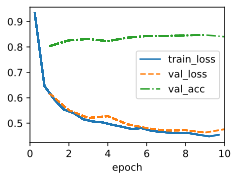

In [10]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]


In [11]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

(256,)

We are more interested in the images we label *incorrectly*. We visualize them by
comparing their actual labels
(first line of text output)
with the predictions from the model
(second line of text output).


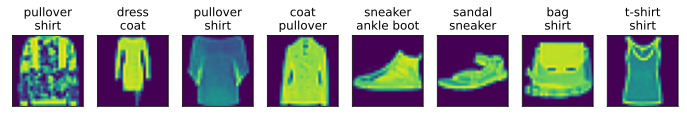

In [12]:
wrong = preds.astype(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

## Summary

By now we are starting to get some experience
with solving linear regression
and classification problems.
With it, we have reached what would arguably be
the state of the art of 1960-1970s of statistical modeling.
In the next section, we'll show you how to leverage
deep learning frameworks to implement this model
much more efficiently.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in :numref:`sec_softmax` this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$?
    1. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?
    1. Implement a fix by looking at the value relative to the largest entry in the argument.
1. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example above.
    1. Why do you think it runs more slowly?
    1. Should you use it? In which cases would it make sense?
    1. What do you need to be careful of? Hint: consider the domain of the logarithm.
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
1. Experiment with the hyperparameters of the code above. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    1. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?


[Discussions](https://discuss.d2l.ai/t/50)
